In [2]:
import sys
import os
sys.path.append("../")

import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import mplhep as hep
from coffea.util import load
import numpy as np
import pandas as pd
import awkward as ak
from coffea.nanoevents import NanoEventsFactory, NanoAODSchema
from rich import print as rich_print

from pprint import pprint 
hep.style.use(hep.style.ROOT)

import hist

from numba import njit

In [124]:
#filename = "/pnfs/psi.ch/cms/trivcat/store/user/mmarcheg/ttHbb/store/mc/RunIISummer20UL18NanoAODv9/ttHTobb_M125_TuneCP5_13TeV-powheg-pythia8/NANOAODSIM/106X_upgrade2018_realistic_v16_L1v1-v2/2500000/6BF93845-49D5-2547-B860-4F7601074715.root"
#filename= "root://rdr.echo.stfc.ac.uk//store/mc/RunIISummer20UL16NanoAODAPVv9/ttHTobb_ttToSemiLep_M125_TuneCP5_13TeV-powheg-pythia8/NANOAODSIM/106X_mcRun2_asymptotic_preVFP_v11-v1/60000/A578687F-E801-D747-9EDB-5E3CF99A9C5A.root"
filename = "root://storage01.lcg.cscs.ch:1096//pnfs/lcg.cscs.ch/cms/trivcat//store/user/dvalsecc/PrivateMC/ttHbb_p1j_tbarlnutqq_madspin_EFTcenter_v1/RunIISummer20UL18MiniAODv2-106X_upgrade2018_realistic_v16_L1v1-NANOAODSIM/240924_221741/0000/nanoAOD_step_100.root"
#events = NanoEventsFactory.from_root(filename, schemaclass=NanoAODSchema).events()
events = NanoEventsFactory.from_root(filename, schemaclass=NanoAODSchema, entry_stop=100000).events()

genparts = events.GenPart

In [125]:
events

<NanoEventsArray [<event 1:101:11>, ... ] type='2364 * event'>

In [126]:
N_genpart_event = ak.num(genparts, axis=1)
#genpart_index_offset = np.concatenate([[0],np.cumsum(N_genpart_event)])
genpart_index_offset = np.concatenate([[0],np.cumsum(ak.to_numpy(ak.num(genparts, axis=1), allow_missing=True))])
genparts_flat = ak.flatten(genparts)

def reverse_index(idxG):
    event_idx = ak.local_index(genpart_index_offset)[(genpart_index_offset-idxG) > 0][0] - 1
    genpart_idx =  idxG - genpart_index_offset[event_idx]
    return event_idx, genpart_idx

def print_tree(idxG, offset=0):
    part = genparts_flat[idxG]
    idx = reverse_index(idxG)
    
    
    if part.hasFlags(['fromHardProcess','isHardProcess', 'isPrompt', 'isFirstCopy']) and part.status!=21:
        print('+ '*offset + f"pdgId:{part.pdgId}, status:{part.status}, GenPart {idx}, mother {part.genPartIdxMother}, fromHardProcess:{int(part.hasFlags(['fromHardProcess']))}, \
isHardProcess:{int(part.hasFlags(['isHardProcess']))}, isPrompt:{int(part.hasFlags(['isPrompt']))}, isFirstCopy:{int(part.hasFlags(['isFirstCopy']))}, \
isLastCopy:{int(part.hasFlags(['isLastCopy']))}         pt:{part.pt:.3f}, eta:{part.eta:.3f}, phi:{part.phi:.3f}", end="")
        print("         --> initial copy, hard process ", end="")
    else:
        print('| '*offset + f"pdgId:{part.pdgId}, status:{part.status}, GenPart {idx}, mother {part.genPartIdxMother}, fromHardProcess:{int(part.hasFlags(['fromHardProcess']))}, \
isHardProcess:{int(part.hasFlags(['isHardProcess']))}, isPrompt:{int(part.hasFlags(['isPrompt']))}, isFirstCopy:{int(part.hasFlags(['isFirstCopy']))}, \
isLastCopy:{int(part.hasFlags(['isLastCopy']))}         pt:{part.pt:.3f}, eta:{part.eta:.3f}, phi:{part.phi:.3f}", end="")
    print()
    
    
    child = part.childrenIdxG
    #has_children = len(child)>0
    for partIdx in child:
        print_tree(partIdx, offset+1)
        
def print_tree_event(iev, idx):
    idxG = genpart_index_offset[iev] + idx
    print_tree(idxG)

In [127]:
print_tree_event(0,2)

pdgId:6, status:22, GenPart (0, 2), mother 0, fromHardProcess:1, isHardProcess:1, isPrompt:1, isFirstCopy:1, isLastCopy:0         pt:307.000, eta:0.338, phi:-2.961         --> initial copy, hard process 
| pdgId:6, status:62, GenPart (0, 10), mother 2, fromHardProcess:1, isHardProcess:0, isPrompt:1, isFirstCopy:0, isLastCopy:1         pt:195.000, eta:-0.289, phi:-2.461
+ + pdgId:5, status:23, GenPart (0, 13), mother 10, fromHardProcess:1, isHardProcess:1, isPrompt:1, isFirstCopy:1, isLastCopy:0         pt:106.500, eta:0.174, phi:-1.973         --> initial copy, hard process 
| | | pdgId:5, status:71, GenPart (0, 40), mother 13, fromHardProcess:1, isHardProcess:0, isPrompt:1, isFirstCopy:0, isLastCopy:1         pt:99.500, eta:0.173, phi:-2.008
| | | pdgId:-513, status:2, GenPart (0, 43), mother 13, fromHardProcess:0, isHardProcess:0, isPrompt:1, isFirstCopy:1, isLastCopy:1         pt:88.250, eta:0.179, phi:-2.000
| | | | pdgId:-511, status:2, GenPart (0, 58), mother 43, fromHardProcess:

In [128]:
def get_reverse_index_func(genparts):
    '''Builds a function compiled in numba to compute the reverse index from the genPartIdxMotherG global index.
    It works also with masked genparticles because the offsets is computed from the first genparticle of each event'''
    # This line is needed to get the global index of the first particle
    # first particle --> first childre --> genPartIdxMotherG
    firstgenpart_idxG = ak.firsts(genparts[:,0].children).genPartIdxMotherG
    firstgenpart_idxG_numpy = ak.to_numpy(firstgenpart_idxG, allow_missing=False)
    local_ind = ak.to_numpy(ak.local_index(firstgenpart_idxG), allow_missing=False)
    genparts_offsets = np.concatenate([[0],np.cumsum(ak.to_numpy(ak.num(genparts, axis=1), allow_missing=True))])
    nevents = firstgenpart_idxG_numpy.shape[0]
    print(nevents)
    
    @njit
    def reverse_index(idxG):
        event_idex = 0
        genpart_idx = 0
        found = False
        for j in range(nevents-1):
            if (firstgenpart_idxG_numpy[j+1] - idxG)>0:
                genpart_idx = idxG - firstgenpart_idxG_numpy[j]
                return j , genpart_idx
                found=True
                break
        if not found:
            genpart_idx = idxG - firstgenpart_idxG_numpy[nevents-1]
            return nevents-1, genpart_idx

    @njit
    def reverse_index_flat(idxG):
        '''Returns the index in the genparticle collection from the global indec. 
        N.B: if the genparts array has not been cut it is an identity. 
        If there have been masks this function converts correctly the global index to the new index'''
        event_idex = 0
        genpart_idx = 0
        found = False
        for j in range(nevents-1):
            if (firstgenpart_idxG_numpy[j+1] - idxG)>0:
                genpart_idx = idxG - firstgenpart_idxG_numpy[j]
                return genparts_offsets[j] + genpart_idx

        if not found:
            genpart_idx = idxG - firstgenpart_idxG_numpy[nevents-1]
            return genparts_offsets[nevents-1] + genpart_idx
        
    @njit
    def reverse_index_array(idxGs):
        out = np.zeros(len(idxGs), dtype="int64")
        for i, idxG in enumerate(idxGs):
            event_idex = 0
            genpart_idx = 0
            found = False
            for j in range(nevents-1):
                if (firstgenpart_idxG_numpy[j+1] - idxG)>0:
                    genpart_idx = idxG - firstgenpart_idxG_numpy[j]
                    out[i] = genparts_offsets[j] + genpart_idx
                    found=True
                    break
            if not found:
                genpart_idx = idxG - firstgenpart_idxG_numpy[nevents-1]
                out[i] = genparts_offsets[nevents-1] + genpart_idx

        return out
    
    return reverse_index, reverse_index_flat, reverse_index_array


reverse_index, reverse_index_flat, reverse_index_array = get_reverse_index_func(genparts)

2364


# Functions

In [129]:
@njit
def analyze_W_flat(W_idx, children_idx,genparts ):
    is_leptonic = np.zeros(len(W_idx), dtype="bool")
    idx_children = np.zeros((len(W_idx),2), dtype="int")
    # We don't have a events, structure, using only flat collections
    
    # First go to children until don't find anymore the same copy
    for iev, W_id in enumerate(W_idx):
        #print("-----\nevent: ", iev)
        if W_id == -1:
            # Special case where the W is not found
            continue
        current_part = W_id # start from the W
        while True:
            #print(iev, current_part, genparts[current_part].pdgId)
            if genparts[current_part].statusFlags & 1<<13:  # is lastCopy
                break
            else:
                current_part = reverse_index_array(children_idx[current_part])[0]
                #print(current)
                # ASSUMING THAT THE FIRST CHILDREN IS THE COPY
#                 if abs(genparts[current_part].pdgId) != 24:
#                     print("BIG ERROR")
        
            
        # We have now at least 2 children, checking if they are leptonic
        for ich,  cidx in enumerate(reverse_index_array(children_idx[current_part])):
            if 11<= abs(genparts[cidx].pdgId) <= 16:
                #print("Found leptonic")
                is_leptonic[iev] = True
            idx_children[iev, ich] = cidx
        
    return is_leptonic, idx_children

In [130]:
@njit
def analyze_parton_decays_flat_nomesons(parts_idx, children_idx, genparts, max_deltaR):
    '''Expects parts_idx in global index and chioldren_idx not.'''
    
    out = np.zeros(parts_idx.shape, dtype="int64")
    
    for iev in range(parts_idx.shape[0]):
        
    #for iev, (gp, ch_idx) in enumerate(zip(genparts, children_idx)):
        for ipart in range(parts_idx.shape[1]):
            p_id = parts_idx[iev][ipart]
            eta_original = genparts[p_id].eta
            phi_original = genparts[p_id].phi
            
            
            # Take all the children and consider the one with the highest pt. 
            max_pt = -1
            max_pt_idx = -1
            childr_idxs = reverse_index_array(children_idx[p_id])
            
            for r_ich in childr_idxs:
                genp = genparts[r_ich]
                # Do no consider mesons
                if abs(genp.pdgId) > 21:
                    continue
                
                if np.sqrt((eta_original-genp.eta)**2 +(phi_original-genp.phi)**2 ) > max_deltaR:
                    continue
                    
                child_pt = genp.pt
                
                #print(child_pt)
                if child_pt > max_pt:
                    max_pt_idx = r_ich
                    max_pt = child_pt
            if max_pt == -1:
                max_pt_idx = p_id
            
            out[iev, ipart] = max_pt_idx
        
    return out

# Running the algos

In [131]:
children_idxG = ak.without_parameters(genparts.childrenIdxG, behavior={})
children_idxG_flat = ak.flatten(children_idxG, axis=1)
genparts_flat = ak.flatten(genparts)
genparts_offsets = np.concatenate([[0],np.cumsum(ak.to_numpy(ak.num(genparts, axis=1), allow_missing=True))])
local_index_all = ak.local_index(genparts, axis=1)

# Get the initial partons, first copy
#initial = genparts.genPartIdxMother == 0
hard_process = (genparts.hasFlags(['fromHardProcess','isPrompt','isHardProcess', 'isFirstCopy'])) & (genparts.status !=21) # exclude incoming particles
genparts_hard = genparts[hard_process]

# I want to take hardProcess, final state, BEFORE FSR particles, which have higgs, top, antitop as parents
from_higgs = genparts_hard.parent.pdgId == 25
from_top = genparts_hard.parent.pdgId == 6
from_antitop = genparts_hard.parent.pdgId == -6

higgs = genparts_hard[genparts_hard.pdgId == 25]
top = genparts_hard[genparts_hard.pdgId == 6]
antitop = genparts_hard[genparts_hard.pdgId == -6]

#genparts_initial = genparts[initial]

# Does not work for the Madgraph sample
#isr = genparts_initial[(genparts_initial.hasFlags(['fromHardProcess','isPrompt','isHardProcess'])) &
                         # (genparts_initial.status == 23) & (genparts_initial.pdgId != 25)& (abs(genparts_initial.pdgId) != 6)]
#has_isr = ak.num(isr)!=0
#isr_idx = ak.flatten(ak.fill_none(ak.pad_none(local_index_all[initial][(genparts_initial.hasFlags(['fromHardProcess','isPrompt','isHardProcess'])) &
                        #  (genparts_initial.status == 23) & (genparts_initial.pdgId != 25)& (abs(genparts_initial.pdgId) != 6)], 1), 0))

# More general ISR matching
outgoing_mask = (genparts.hasFlags(['fromHardProcess','isPrompt','isHardProcess'])) & (genparts.status == 23)
outgoing = genparts[outgoing_mask]

isr = outgoing[outgoing.parent.status==21]
has_isr = ak.num(isr)!=0
isr_idx =  ak.flatten(ak.fill_none(ak.pad_none(local_index_all[outgoing_mask][outgoing.parent.status==21], 1),0))


In [132]:
isr_idx

<Array [5, 5, 5, 5, 5, 5, ... 0, 5, 5, 5, 5, 5] type='2364 * int64'>

## Decays of the tops

In [133]:
######
part_from_top = genparts_hard[from_top]

# in some events the w is not saved explicitely but already its decays. in those cases we insert a None in the W_from_top
W_from_top = ak.flatten(ak.pad_none(part_from_top[part_from_top.pdgId ==24], 1, axis=1))
W_from_top_exist = ~ak.is_none(W_from_top)
b_from_top = ak.flatten(part_from_top[part_from_top.pdgId ==5])

part_from_antitop = genparts_hard[from_antitop]
# in some events the w is not saved explicitely but already its decays. in those cases we insert a None in the W_from_top
W_from_antitop = ak.flatten(ak.pad_none(part_from_antitop[part_from_antitop.pdgId ==-24], 1, axis=1))
W_from_antitop_exist = ~ak.is_none(W_from_antitop)
b_from_antitop = ak.flatten(part_from_antitop[part_from_antitop.pdgId == -5])

b_from_top_idx = ak.flatten(local_index_all[hard_process][from_top][part_from_top.pdgId ==5])
W_from_top_idx = ak.flatten(ak.pad_none(local_index_all[hard_process][from_top][part_from_top.pdgId == 24],1, axis=1))
b_from_antitop_idx = ak.flatten(local_index_all[hard_process][from_antitop][part_from_antitop.pdgId == -5])
W_from_antitop_idx = ak.flatten(ak.pad_none(local_index_all[hard_process][from_antitop][part_from_antitop.pdgId == -24],1, axis=1))

W_from_top_idx = ak.fill_none(W_from_top_idx, 0)
W_from_antitop_idx = ak.fill_none(W_from_antitop_idx, 0)

# This works because they are the firstCopy of the hard_process particles with higgs as parent. We are skipping all the decay chain of the higgs
b_from_higgs_idx = local_index_all[hard_process][from_higgs]
b_from_higgs = genparts_hard[from_higgs]


In [134]:
#--------------
b_from_top_idxG = ak.to_numpy(b_from_top_idx + genparts_offsets[:-1], allow_missing=False)
W_from_top_idxG = ak.to_numpy(W_from_top_idx + genparts_offsets[:-1], allow_missing=False)
b_from_antitop_idxG = ak.to_numpy(b_from_antitop_idx + genparts_offsets[:-1], allow_missing=False)
W_from_antitop_idxG = ak.to_numpy(W_from_antitop_idx + genparts_offsets[:-1], allow_missing=False)
isr_idxG = ak.to_numpy(isr_idx + genparts_offsets[:-1], allow_missing=False)
b_from_higgs_idxG = ak.to_numpy(b_from_higgs_idx + genparts_offsets[:-1], allow_missing=False)
W_from_top_exist = ak.to_numpy(W_from_top_exist)
W_from_antitop_exist = ak.to_numpy(W_from_antitop_exist)

# Putting -1 in the index if the W is missing 
W_from_top_idxG = np.where(W_from_top_exist, W_from_top_idxG, -1)
W_from_antitop_idxG = np.where(W_from_antitop_exist, W_from_antitop_idxG, -1)

Now we have some events where the W is not a GenParticle, but we can get the decays from the `from_top` variable in that case

In [135]:
higgs_from_bs = b_from_higgs[:,0] + b_from_higgs[:,1]

In [136]:
higgs_LHE = events.LHEPart[events.LHEPart.pdgId==25]

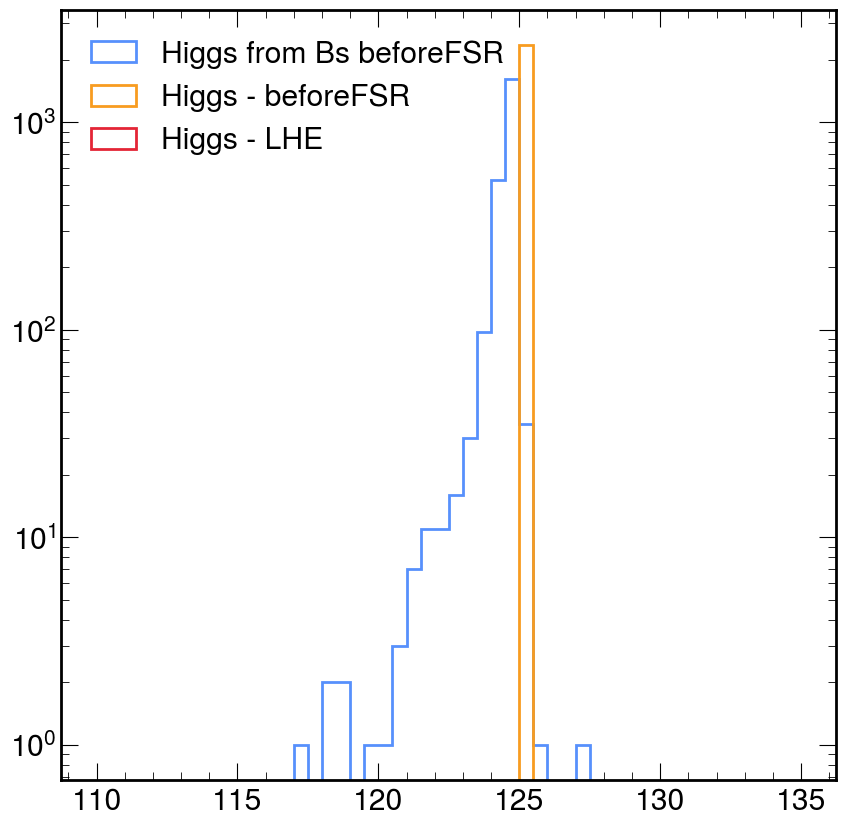

In [137]:
plt.hist(higgs_from_bs.mass, bins=50, range=(110, 135), histtype="step",label="Higgs from Bs beforeFSR", linewidth=2);
plt.hist(higgs.mass, bins=50, range=(110, 135), histtype="step", label="Higgs - beforeFSR", linewidth=2);
plt.hist(higgs_LHE.mass, bins=50, range=(110, 135), histtype="step", label="Higgs - LHE", linewidth=2);
plt.legend()
plt.yscale("log");

In [138]:
W_from_top_islep, W_from_top_decay = analyze_W_flat( W_from_top_idxG, 
                                                      children_idxG_flat,
                                                      ak.without_parameters(ak.flatten(genparts, axis=1),behavior={}))

W_from_antitop_islep, W_from_antitop_decay = analyze_W_flat( W_from_antitop_idxG, 
                                                              children_idxG_flat,
                                                              ak.without_parameters(ak.flatten(genparts, axis=1),behavior={}))
# Remember that is the W does not exist the index 0 is returned
# We need to mask it later
part_from_Wtop = genparts_flat[W_from_top_decay]
part_from_Wantitop = genparts_flat[W_from_antitop_decay]

We need to analyze the decayse of the top when the W is not found

In [139]:
direct_Wdecays_fromtop = part_from_top[(abs(part_from_top.pdgId)!=5) & (abs(part_from_top.pdgId)!=24)]
direct_Wdecays_fromantitop = part_from_antitop[(abs(part_from_antitop.pdgId)!=5) & (abs(part_from_antitop.pdgId)!=24)]

direct_W_from_top_islep = ak.sum(abs(direct_Wdecays_fromtop.pdgId), axis=1)>=23
direct_W_from_top_decay_idx = local_index_all[hard_process][from_top][(abs(part_from_top.pdgId)!=5) & (abs(part_from_top.pdgId)!=24)]
direct_W_from_top_decay_idxG = direct_W_from_top_decay_idx + genparts_offsets[:-1]

direct_W_from_antitop_islep = ak.sum(abs(direct_Wdecays_fromantitop.pdgId), axis=1)>=23
direct_W_from_antitop_decay_idx = local_index_all[hard_process][from_antitop][(abs(part_from_antitop.pdgId)!=5) & (abs(part_from_antitop.pdgId)!=24)]
direct_W_from_antitop_decay_idxG = direct_W_from_antitop_decay_idx + genparts_offsets[:-1]

In [140]:
W_had_decay_idx = np.where((~W_from_top_islep & W_from_top_exist)[:, None], W_from_top_decay, np.zeros((len(W_from_top_decay), 2), dtype=int))
W_had_decay_idx = np.where((~W_from_antitop_islep & W_from_antitop_exist)[:,None], W_from_antitop_decay, W_had_decay_idx )

W_lep_decay_idx = np.where((W_from_top_islep & W_from_top_exist)[:,None], W_from_top_decay,  np.zeros((len(W_from_top_decay), 2), dtype=int) )
W_lep_decay_idx = np.where((W_from_antitop_islep & W_from_antitop_exist)[:,None], W_from_antitop_decay, W_lep_decay_idx)

# adding back the directW decays

W_had_decay_idx_direct = np.where(~direct_W_from_top_islep & ~W_from_top_exist, direct_W_from_top_decay_idxG, np.zeros((len(W_from_top_decay), 2), dtype=int) )
W_had_decay_idx_direct = np.where(~direct_W_from_antitop_islep & ~W_from_antitop_exist, direct_W_from_antitop_decay_idxG, W_had_decay_idx_direct)

W_lep_decay_idx_direct = np.where(direct_W_from_top_islep & ~W_from_top_exist,  direct_W_from_top_decay_idxG, np.zeros((len(W_from_top_decay), 2), dtype=int))
W_lep_decay_idx_direct = np.where(direct_W_from_antitop_islep & ~W_from_antitop_exist,direct_W_from_antitop_decay_idxG, W_lep_decay_idx_direct)

W_had_from_direct = ak.sum(W_had_decay_idx_direct, axis=1)>0
W_lep_from_direct = ak.sum(W_lep_decay_idx_direct, axis=1)>0

W_had_decay_idx = ak.to_numpy(np.where(W_had_from_direct, W_had_decay_idx_direct, W_had_decay_idx), allow_missing=False)
W_lep_decay_idx = ak.to_numpy(np.where(W_lep_from_direct, W_lep_decay_idx_direct, W_lep_decay_idx), allow_missing=False)

part_from_Whad = genparts_flat[W_had_decay_idx]
part_from_Wlep = genparts_flat[W_lep_decay_idx]

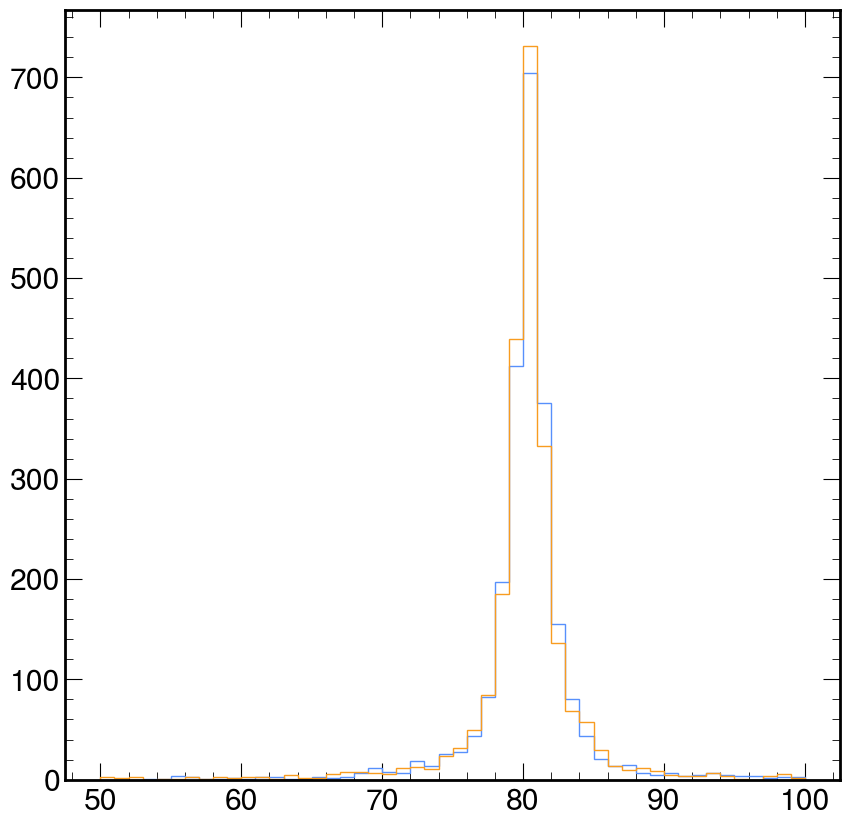

In [141]:
plt.hist((part_from_Whad[:,0] + part_from_Whad[:,1]).mass, bins=50, range=(50,100), histtype="step")
plt.hist((part_from_Wlep[:,0] + part_from_Wlep[:,1]).mass, bins=50, range=(50,100), histtype="step");

In [142]:
# assuming semilep only
W_had = np.where(~W_from_top_islep[:,None],W_from_top_decay, W_from_antitop_decay )

In [143]:
part_input_G  = np.concatenate([b_from_top_idxG[:,None],
                                        b_from_antitop_idxG[:,None],
                                        b_from_higgs_idxG,
                                        isr_idxG[:,None],
                                        W_had_decay_idx,
                                        ], axis=1)

parton_decay_id = analyze_parton_decays_flat_nomesons(part_input_G,
                          children_idxG_flat,
                         ak.without_parameters(ak.flatten(genparts, axis=1),behavior={}), max_deltaR=1)



In [144]:
b_from_top_lastcopy = genparts_flat[parton_decay_id[:,0]]
b_from_antitop_lastcopy = genparts_flat[parton_decay_id[:,1]]
b_from_higgs_lastcopy = genparts_flat[parton_decay_id[:,2:4]]
isr_lastcopy = genparts_flat[parton_decay_id[:,4]]
part_from_Whad_lastcopy = genparts_flat[parton_decay_id[:,5:7]]
# We don't take the last copy of the leptonic particles, but the born one
part_from_Wlep = genparts_flat[W_lep_decay_idx]

# Now we can perform the genmatching
quarks_initial = genparts_flat[part_input_G]
quarks_lastcopy = genparts_flat[parton_decay_id]

quarks_provenance = np.zeros(parton_decay_id.shape, dtype=np.int32)
quarks_provenance[:, 0] = np.where(W_from_top_islep, 3, 2)  #b from leptonic top =3, hadronic =2
quarks_provenance[:, 1] = np.where(W_from_antitop_islep, 3, 2)
quarks_provenance[:, 2:4] = 1 #Higgs
quarks_provenance[:, 4] = 4 #isr
quarks_provenance[:, 5:7] = 5 #W hadronic decay
quarks_initial["provenance"] = ak.Array(quarks_provenance, behavior={})
quarks_lastcopy["provenance"] = quarks_initial["provenance"]


In [145]:
higgs_from_bs_afterFST = b_from_higgs_lastcopy[:,0] + b_from_higgs_lastcopy[:,1]

/t3home/dvalsecc/micromamba/envs/pocket-coffea/lib/python3.10/site-packages/awkward/_connect/_numpy.py:197: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(


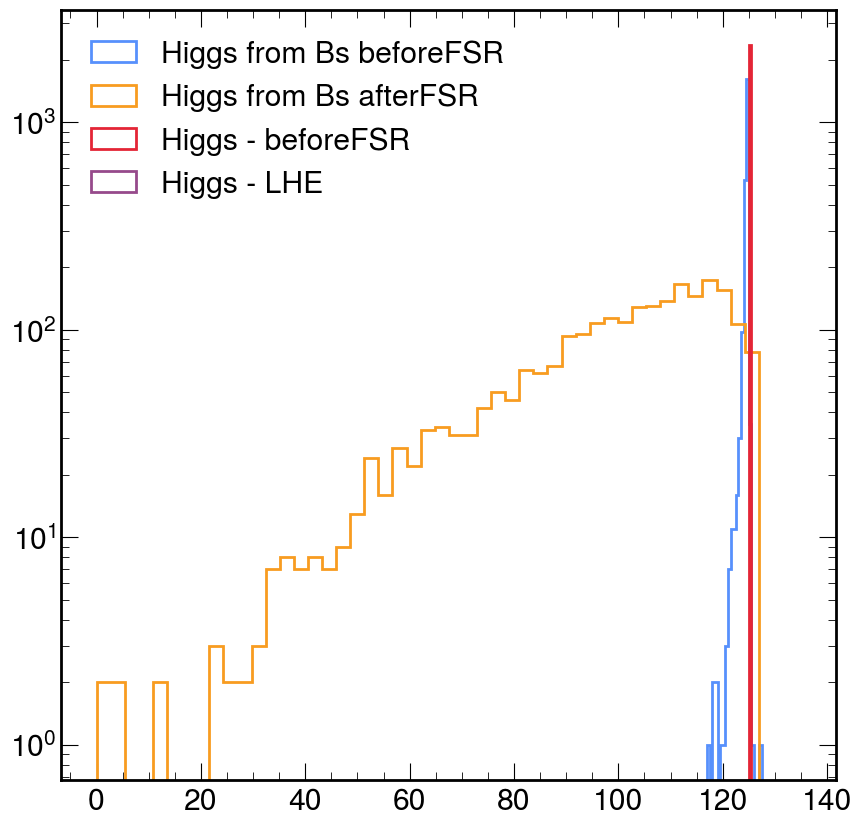

In [146]:
plt.hist(higgs_from_bs.mass, bins=50, range=(110, 135), histtype="step",label="Higgs from Bs beforeFSR", linewidth=2);
plt.hist(higgs_from_bs_afterFST.mass, bins=50, range=(0, 135), histtype="step",label="Higgs from Bs afterFSR", linewidth=2);
plt.hist(higgs.mass, bins=50, range=(110, 135), histtype="step", label="Higgs - beforeFSR", linewidth=2);
plt.hist(higgs_LHE.mass, bins=50, range=(110, 135), histtype="step", label="Higgs - LHE", linewidth=2);
plt.legend()
plt.yscale("log");

In [147]:
higgs

<GenParticleArray [[GenParticle], ... [GenParticle]] type='2364 * var * genParticle'>

# Comparisons firstcopy - lastcopy

Text(0.5, 0.98, 'Gluon ISR')

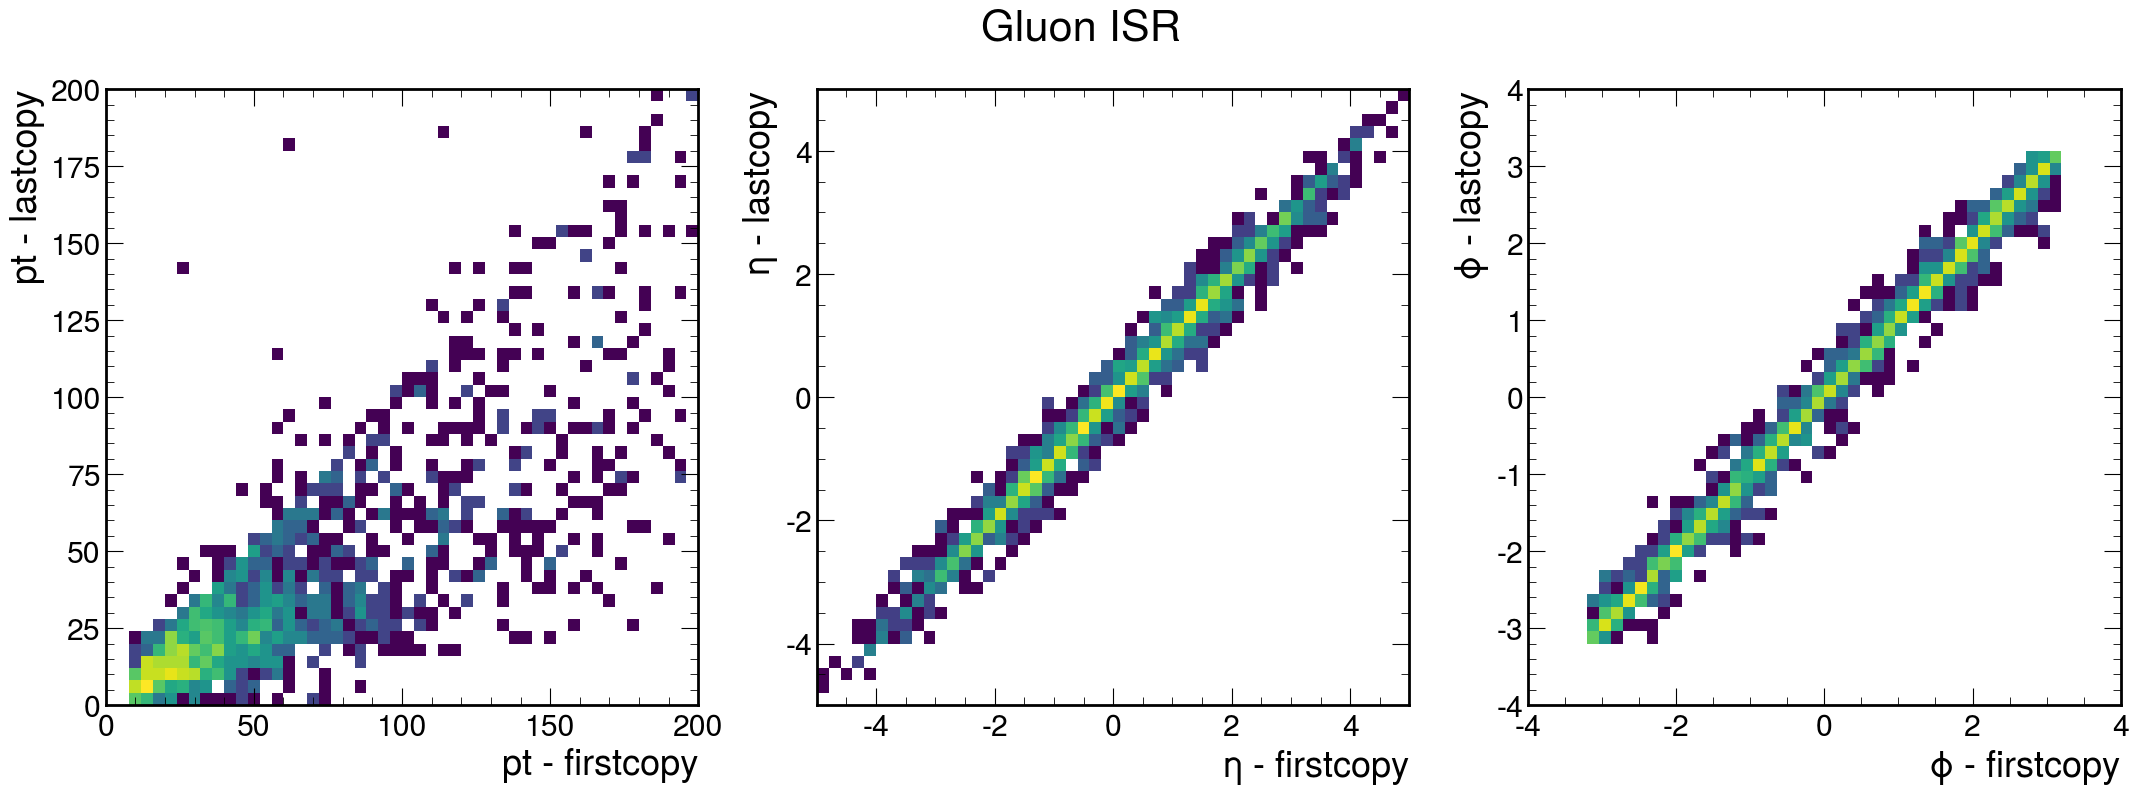

In [148]:
fig, axs = plt.subplots(1, 3, figsize=(26, 8))
has_isr = ak.num(isr, axis=1)>0
var = isr[has_isr,0]
var_lastcopy = isr_lastcopy[has_isr]

axs[0].hist2d(var.pt.to_numpy(),
           var_lastcopy.pt.to_numpy(), bins=(50,50), range=((0,200),(0,200)), norm=LogNorm());
axs[0].set_xlabel("pt - firstcopy")
axs[0].set_ylabel("pt - lastcopy")
axs[1].hist2d(var.eta.to_numpy(),
          var_lastcopy.eta.to_numpy(), bins=(50,50), range=((-5,5),(-5,5)), norm=LogNorm());
axs[1].set_xlabel("$\eta$ - firstcopy")
axs[1].set_ylabel("$\eta$ - lastcopy")
axs[2].hist2d(var.phi.to_numpy(),
           var_lastcopy.phi.to_numpy(), bins=(50,50), range=((-4,4),(-4,4)), norm=LogNorm());
axs[2].set_xlabel("$\phi$ - firstcopy")
axs[2].set_ylabel("$\phi$ - lastcopy")
fig.suptitle("Gluon ISR")

Text(0.5, 0.98, 'Higgs from b-quarks')

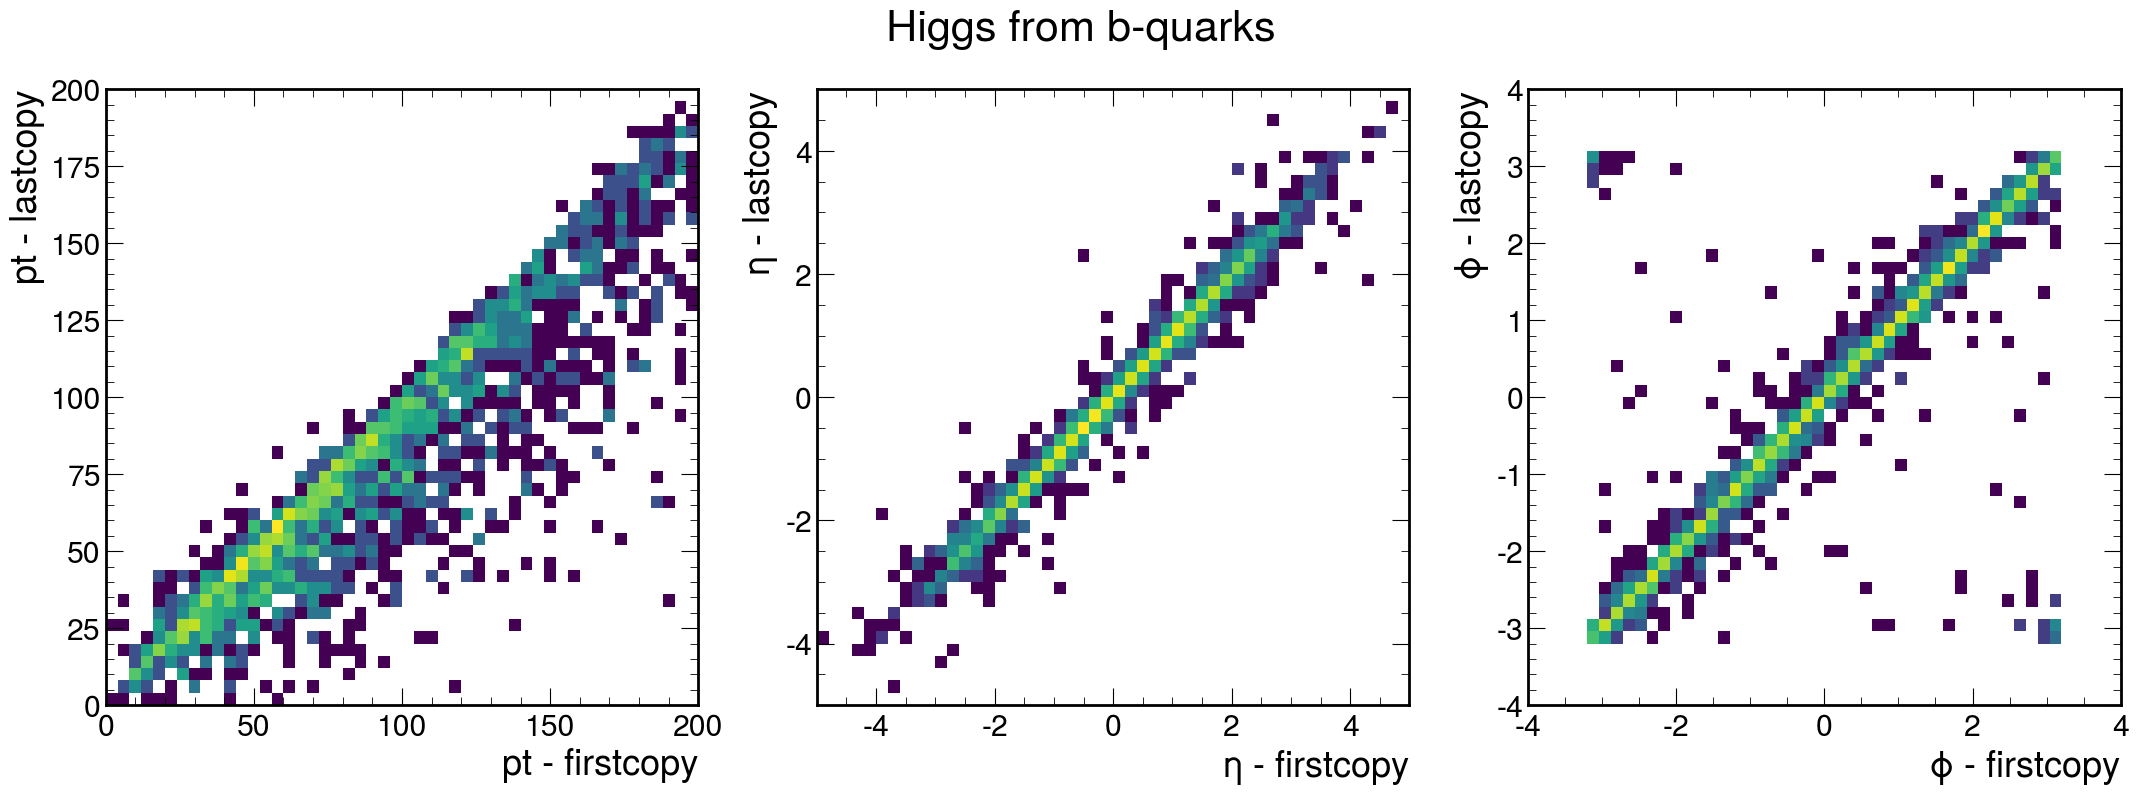

In [149]:
fig, axs = plt.subplots(1, 3, figsize=(26, 8))
var = higgs_from_bs
var_lastcopy = higgs_from_bs_afterFST

axs[0].hist2d(var.pt.to_numpy(),
           var_lastcopy.pt.to_numpy(), bins=(50,50), range=((0,200),(0,200)), norm=LogNorm());
axs[0].set_xlabel("pt - firstcopy")
axs[0].set_ylabel("pt - lastcopy")
axs[1].hist2d(var.eta.to_numpy(),
          var_lastcopy.eta.to_numpy(), bins=(50,50), range=((-5,5),(-5,5)), norm=LogNorm());
axs[1].set_xlabel("$\eta$ - firstcopy")
axs[1].set_ylabel("$\eta$ - lastcopy")
axs[2].hist2d(var.phi.to_numpy(),
           var_lastcopy.phi.to_numpy(), bins=(50,50), range=((-4,4),(-4,4)), norm=LogNorm());
axs[2].set_xlabel("$\phi$ - firstcopy")
axs[2].set_ylabel("$\phi$ - lastcopy")
fig.suptitle("Higgs from b-quarks")

Text(0.5, 0.98, 'b from antitop')

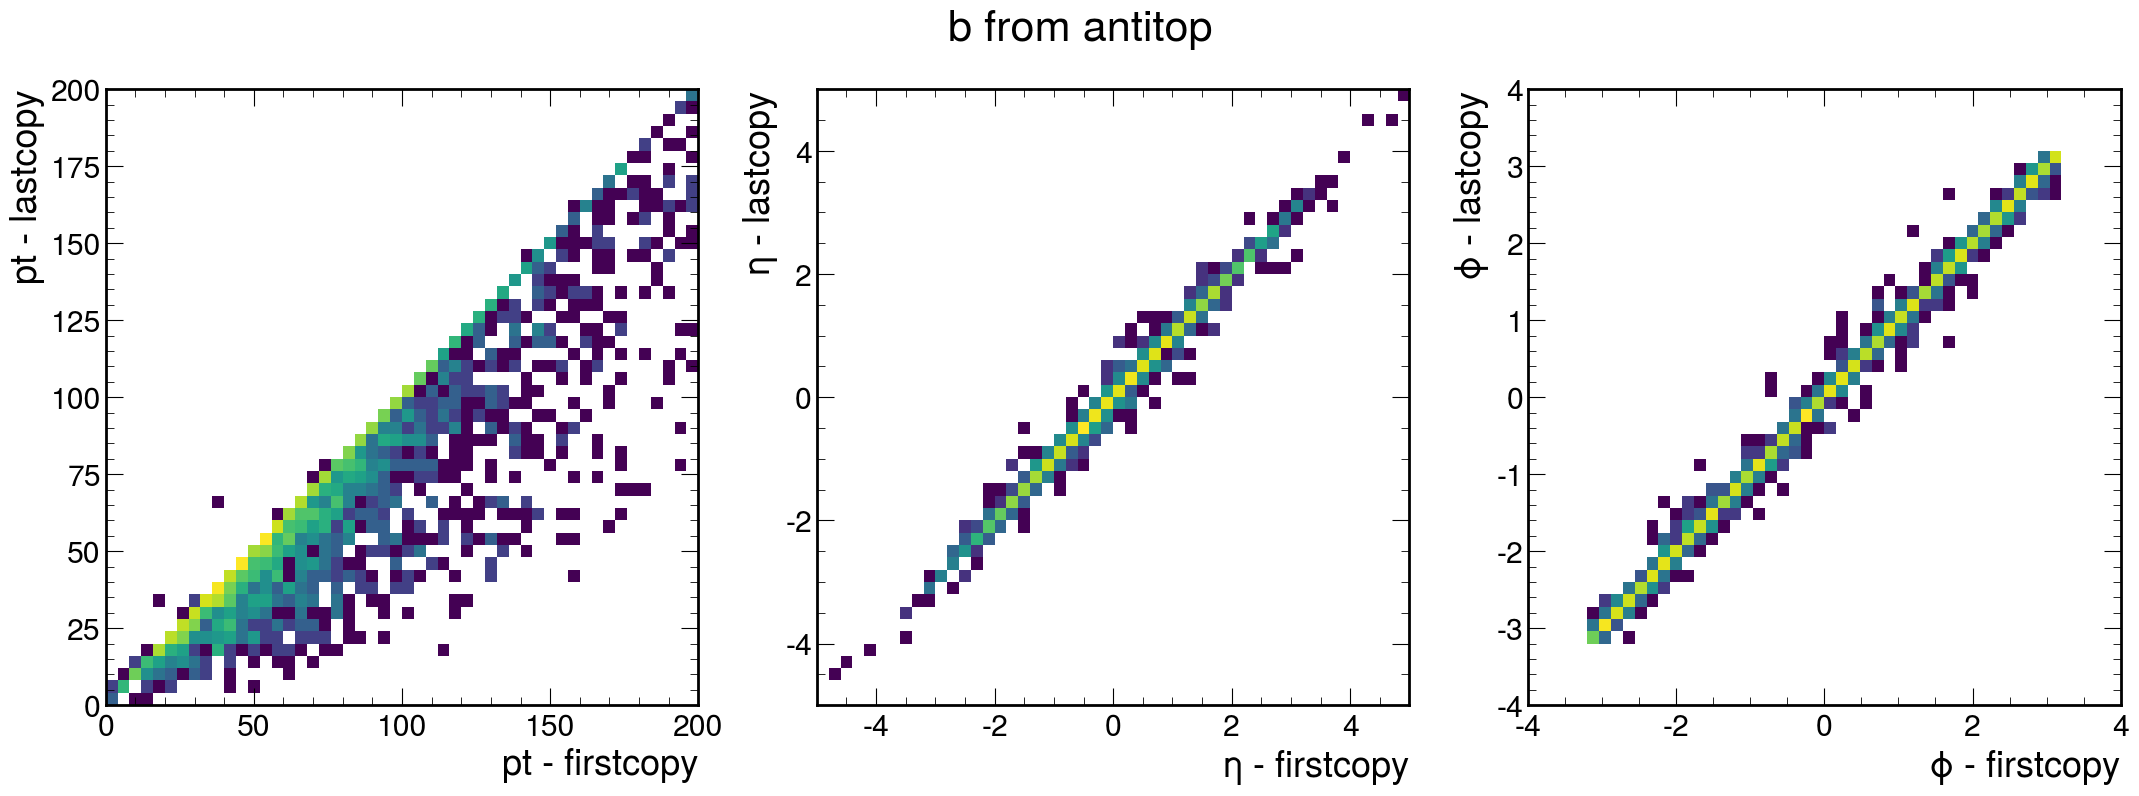

In [150]:
fig, axs = plt.subplots(1, 3, figsize=(26, 8))
axs[0].hist2d(b_from_antitop.pt.to_numpy(),
           b_from_antitop_lastcopy.pt.to_numpy(), bins=(50,50), range=((0,200),(0,200)), norm=LogNorm());
axs[0].set_xlabel("pt - firstcopy")
axs[0].set_ylabel("pt - lastcopy")
axs[1].hist2d(b_from_antitop.eta.to_numpy(),
          b_from_antitop_lastcopy.eta.to_numpy(), bins=(50,50), range=((-5,5),(-5,5)), norm=LogNorm());
axs[1].set_xlabel("$\eta$ - firstcopy")
axs[1].set_ylabel("$\eta$ - lastcopy")
axs[2].hist2d(b_from_antitop.phi.to_numpy(),
           b_from_antitop_lastcopy.phi.to_numpy(), bins=(50,50), range=((-4,4),(-4,4)), norm=LogNorm());
axs[2].set_xlabel("$\phi$ - firstcopy")
axs[2].set_ylabel("$\phi$ - lastcopy")
fig.suptitle("b from antitop")

Text(0.5, 0.98, 'b from top')

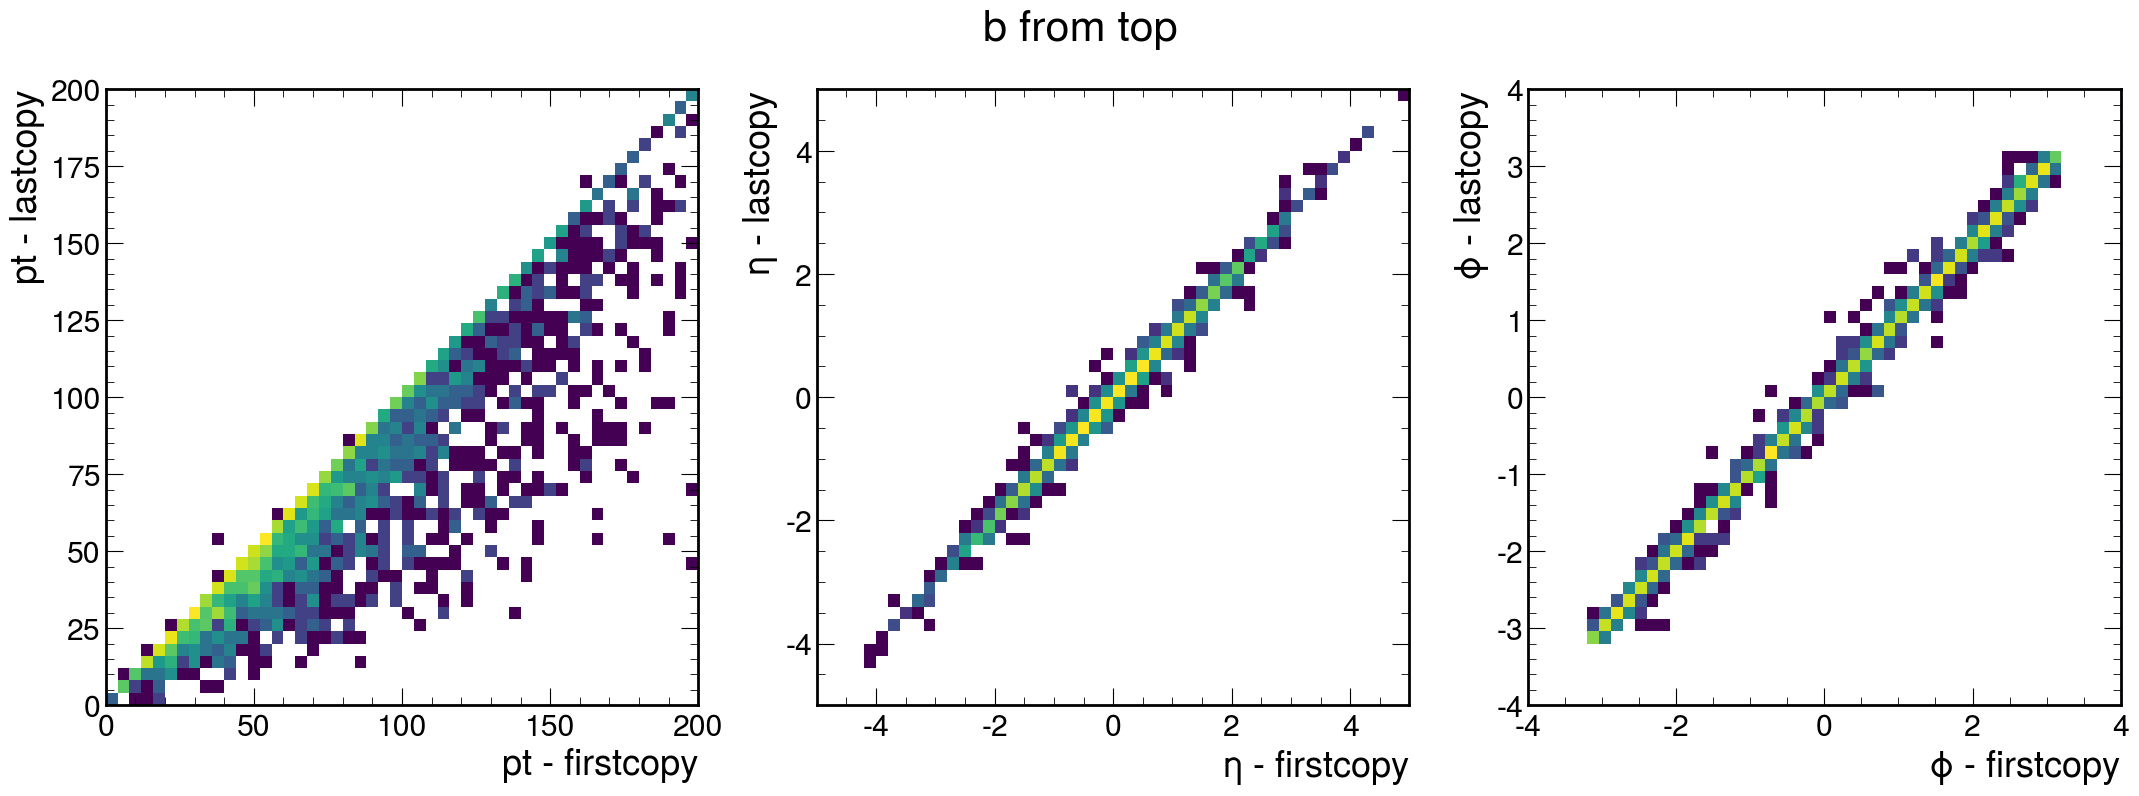

In [151]:
fig, axs = plt.subplots(1, 3, figsize=(26, 8))
axs[0].hist2d(b_from_top.pt.to_numpy(),
           b_from_top_lastcopy.pt.to_numpy(), bins=(50,50), range=((0,200),(0,200)), norm=LogNorm());
axs[0].set_xlabel("pt - firstcopy")
axs[0].set_ylabel("pt - lastcopy")
axs[1].hist2d(b_from_top.eta.to_numpy(),
           b_from_top_lastcopy.eta.to_numpy(), bins=(50,50), range=((-5,5),(-5,5)), norm=LogNorm());
axs[1].set_xlabel("$\eta$ - firstcopy")
axs[1].set_ylabel("$\eta$ - lastcopy")
axs[2].hist2d(b_from_top.phi.to_numpy(),
           b_from_top_lastcopy.phi.to_numpy(), bins=(50,50), range=((-4,4),(-4,4)), norm=LogNorm());
axs[2].set_xlabel("$\phi$ - firstcopy")
axs[2].set_ylabel("$\phi$ - lastcopy")
fig.suptitle("b from top")

Text(0.5, 0.98, 'parton from W had decay')

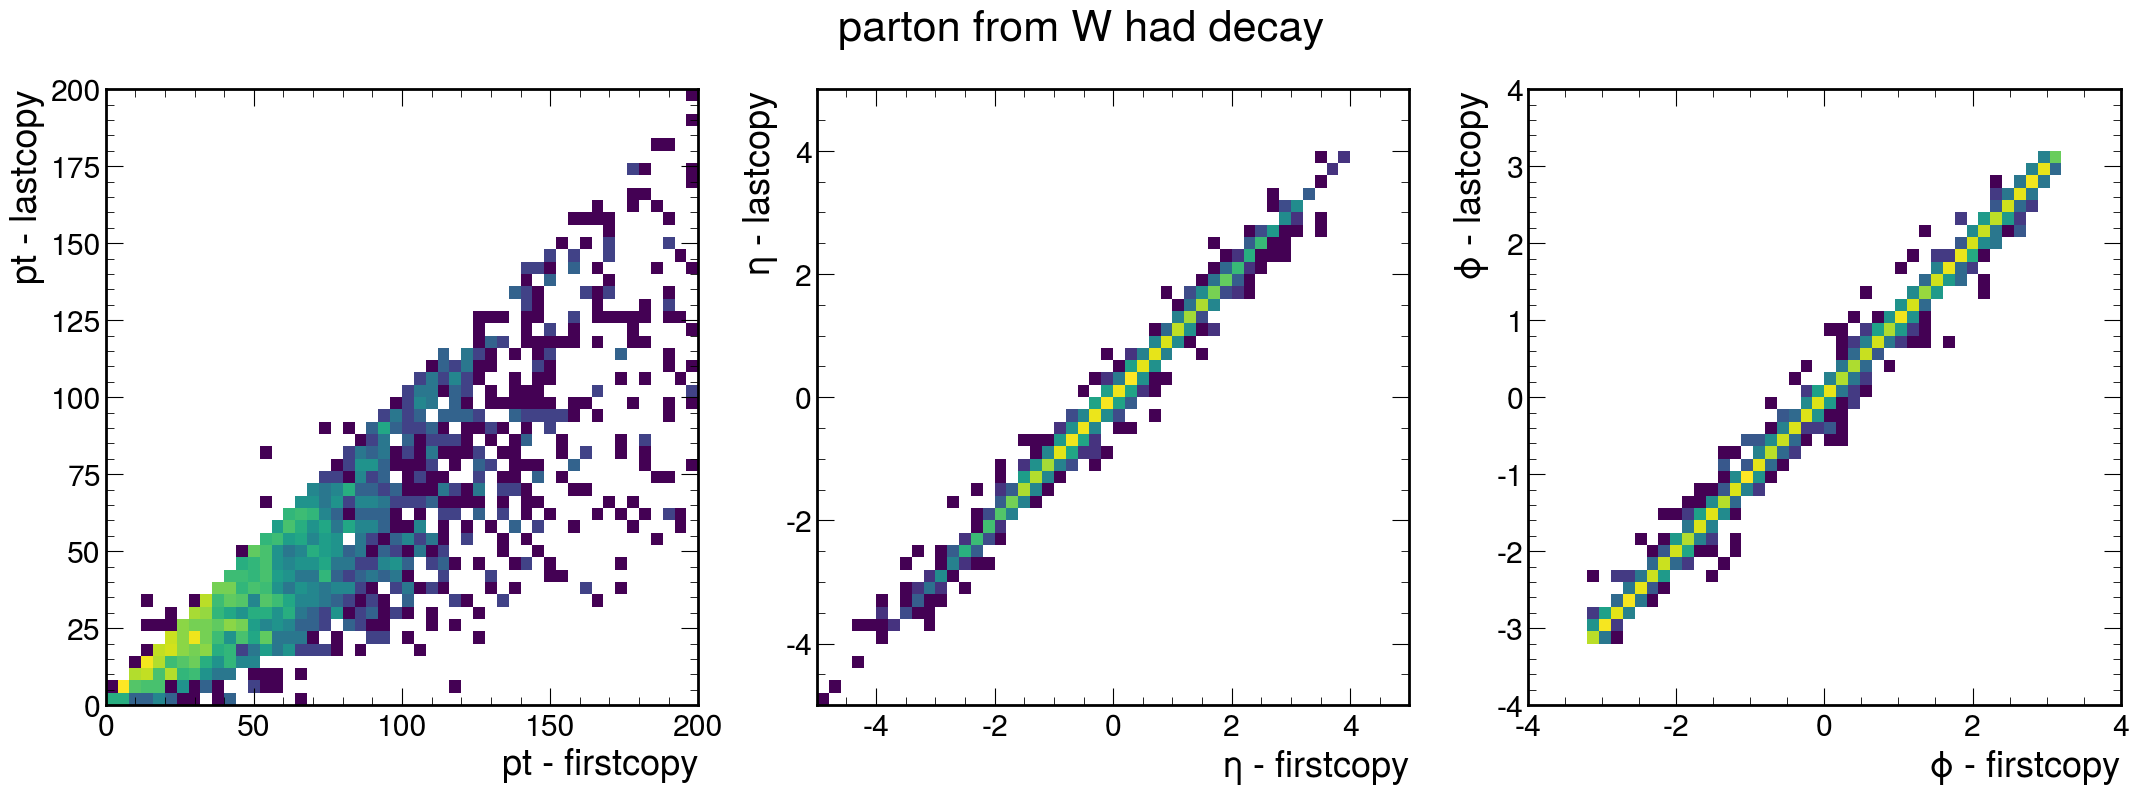

In [152]:
fig, axs = plt.subplots(1, 3, figsize=(26, 8))
var = part_from_Whad[:,0]
var_lastcopy = part_from_Whad_lastcopy[:,0]

axs[0].hist2d(var.pt.to_numpy(),
           var_lastcopy.pt.to_numpy(), bins=(50,50), range=((0,200),(0,200)), norm=LogNorm());
axs[0].set_xlabel("pt - firstcopy")
axs[0].set_ylabel("pt - lastcopy")
axs[1].hist2d(var.eta.to_numpy(),
          var_lastcopy.eta.to_numpy(), bins=(50,50), range=((-5,5),(-5,5)), norm=LogNorm());
axs[1].set_xlabel("$\eta$ - firstcopy")
axs[1].set_ylabel("$\eta$ - lastcopy")
axs[2].hist2d(var.phi.to_numpy(),
           var_lastcopy.phi.to_numpy(), bins=(50,50), range=((-4,4),(-4,4)), norm=LogNorm());
axs[2].set_xlabel("$\phi$ - firstcopy")
axs[2].set_ylabel("$\phi$ - lastcopy")
fig.suptitle("parton from W had decay")

Text(0.5, 0.98, 'parton from W had')

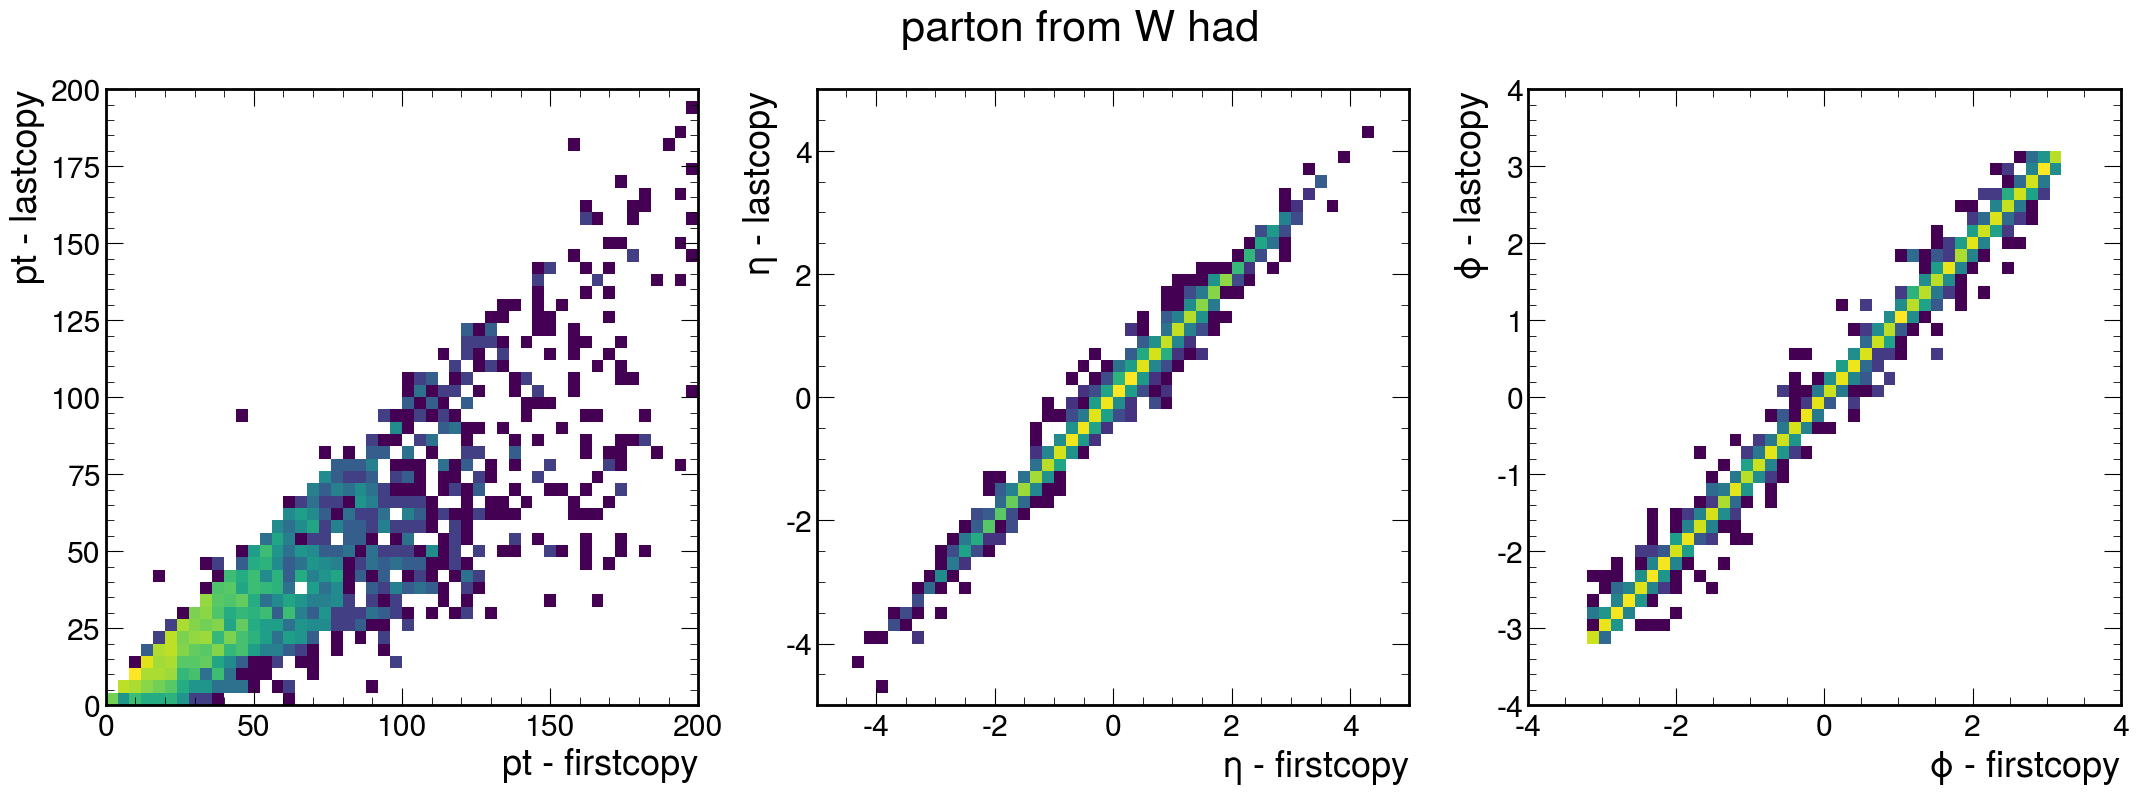

In [153]:
fig, axs = plt.subplots(1, 3, figsize=(26, 8))
var = part_from_Whad[:,1]
var_lastcopy = part_from_Whad_lastcopy[:,1]

axs[0].hist2d(var.pt.to_numpy(),
           var_lastcopy.pt.to_numpy(), bins=(50,50), range=((0,200),(0,200)), norm=LogNorm());
axs[0].set_xlabel("pt - firstcopy")
axs[0].set_ylabel("pt - lastcopy")
axs[1].hist2d(var.eta.to_numpy(),
          var_lastcopy.eta.to_numpy(), bins=(50,50), range=((-5,5),(-5,5)), norm=LogNorm());
axs[1].set_xlabel("$\eta$ - firstcopy")
axs[1].set_ylabel("$\eta$ - lastcopy")
axs[2].hist2d(var.phi.to_numpy(),
           var_lastcopy.phi.to_numpy(), bins=(50,50), range=((-4,4),(-4,4)), norm=LogNorm());
axs[2].set_xlabel("$\phi$ - firstcopy")
axs[2].set_ylabel("$\phi$ - lastcopy")
fig.suptitle("parton from W had")

## DeltaR from firstcopy - lastcopy

Text(1, 0, 'deltaR(firstcopy, lastcopy)')

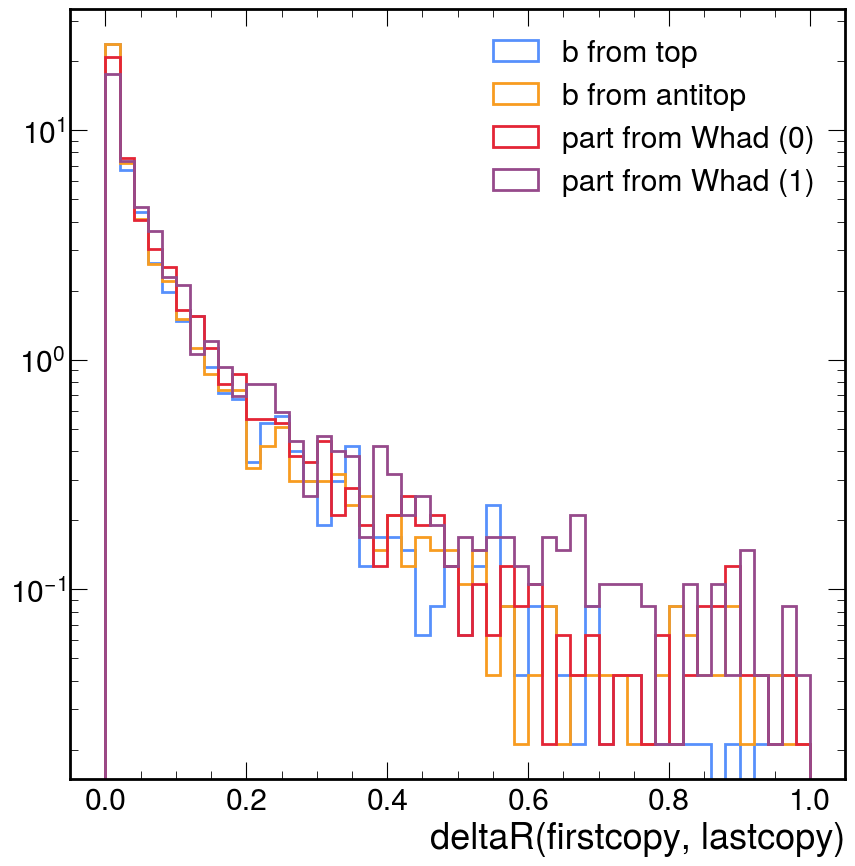

In [154]:
pltcfg = {"histtype":"step", "linewidth":2, "density":True}
H = plt.hist(b_from_top.delta_r(b_from_top_lastcopy), bins=50, range=(0, 1), label="b from top", **pltcfg )
plt.hist(b_from_antitop.delta_r(b_from_antitop_lastcopy), bins=50, range=(0, 1), label="b from antitop", **pltcfg )
plt.hist(part_from_Whad[:,0].delta_r(part_from_Whad_lastcopy[:,0]), bins=50, range=(0, 1), label="part from Whad (0)", **pltcfg )
#plt.hist(part_from_Wantitop[:,0].delta_r(part_from_Wantitop_lastcopy[:,0]), bins=50, range=(0, 1), label="part from Wantitop (0)", **pltcfg )
plt.hist(part_from_Whad[:,1].delta_r(part_from_Whad_lastcopy[:,1]), bins=50, range=(0, 1), label="part from Whad (1)", **pltcfg )
#plt.hist(part_from_Wantitop[:,1].delta_r(part_from_Wantitop_lastcopy[:,1]), bins=50, range=(0, 1), label="part from Wantitop (1)", **pltcfg )
plt.yscale("log")
plt.legend()
plt.xlabel("deltaR(firstcopy, lastcopy)")

Text(1, 0, 'deltaR > x')

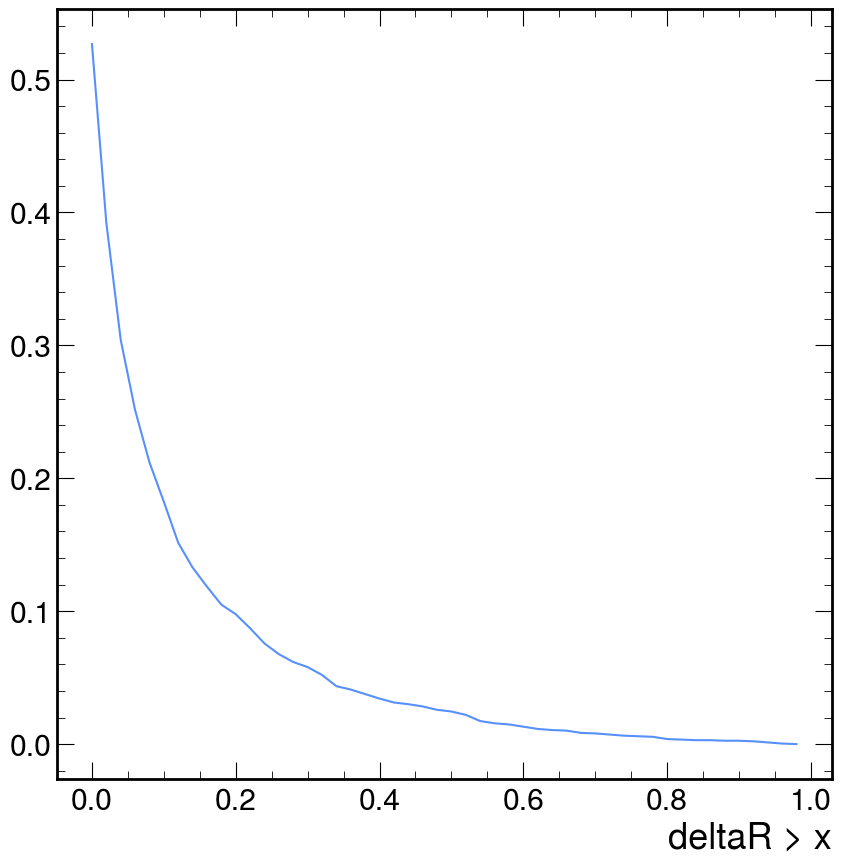

In [155]:
plt.plot(H[1][:-1], 1 - (H[0]/H[0].sum()).cumsum())
plt.xlabel("deltaR > x")

In [156]:
from pocket_coffea.lib.deltaR_matching import object_matching,get_matching_pairs_indices,get_matching_objects_indices_padnone

In [157]:
events

<NanoEventsArray [<event 1:101:11>, ... ] type='2364 * event'>

In [158]:
events.fields

['Generator',
 'PuppiMET',
 'luminosityBlock',
 'GenJetAK8',
 'SubJet',
 'L1Reco',
 'boostedTau',
 'RawPuppiMET',
 'genWeight',
 'fixedGridRhoFastjetAll',
 'Tau',
 'SoftActivityJetHT',
 'IsoTrack',
 'TrigObj',
 'OtherPV',
 'SoftActivityJetNjets5',
 'GenPart',
 'SoftActivityJetNjets10',
 'PV',
 'genTtbarId',
 'HLTriggerFirstPath',
 'TkMET',
 'HTXS',
 'event',
 'PSWeight',
 'Photon',
 'SoftActivityJetHT10',
 'MET',
 'SoftActivityJet',
 'LHEScaleWeight',
 'LHE',
 'L1',
 'DeepMETResponseTune',
 'SoftActivityJetNjets2',
 'Muon',
 'GenVisTau',
 'LHEPart',
 'Pileup',
 'FsrPhoton',
 'run',
 'GenMET',
 'GenJet',
 'GenIsolatedPhoton',
 'SoftActivityJetHT5',
 'HLTriggerFinalPath',
 'Jet',
 'LHEReweightingWeight',
 'SV',
 'fixedGridRhoFastjetCentralNeutral',
 'FatJet',
 'DeepMETResolutionTune',
 'SubGenJetAK8',
 'GenDressedLepton',
 'SoftActivityJetHT2',
 'L1PreFiringWeight',
 'GenVtx',
 'fixedGridRhoFastjetCentral',
 'btagWeight',
 'fixedGridRhoFastjetCentralChargedPileUp',
 'RawMET',
 'CaloMET',

In [159]:
# Calling our general object_matching function.
# The output is an awkward array with the shape of the second argument and None where there is no matching.
# So, calling like this, we will get out an array of matched_quarks with the dimension of the JetGood.
matched_quarks, matched_jets, deltaR_matched = object_matching(
    quarks_initial, events.Jet, dr_min=0.4
)

matched_quarks_lastcopy, matched_jets_lastcopy, deltaR_matched_hard = object_matching(
    quarks_lastcopy, events.Jet, dr_min=0.4
)


In [160]:
matched_quarks.provenance[0:10].tolist()

[[None, 3, 5, None, 1, 2, None, None, None],
 [1, 5, 3, 2, 1, None, 5, None, None, None],
 [2, 1, 3, 5, 1, 4, None, 5, None, None, None, None],
 [5, 3, None, 1, 1, None, 5, 2, None, 4, None, None, None],
 [1, 4, 2, 3, None, 1, None],
 [5, 3, 2, None, None, 5, 1, None],
 [2, 3, None, 4, 5, None, 1],
 [5, 5, 1, 1, None, None, None, None, None],
 [4, 1, 1, None, 2, 5, None, 5, None, None, None],
 [4, 2, None, 5, 5, 1, 1, None, None, None]]

In [161]:
matched_quarks_lastcopy.provenance[0:10].tolist()

[[None, 3, 5, None, 1, 2, None, 4, None],
 [1, 4, 3, 2, 1, 5, 5, None, None, None],
 [2, 1, 3, 5, 1, 4, None, 5, None, None, None, None],
 [5, 3, None, 1, 1, None, 5, 2, 4, None, None, None, None],
 [1, 4, 2, 3, None, 1, None],
 [5, 3, 2, 1, None, 5, 1, None],
 [2, 3, None, 4, 5, 1, 1],
 [5, 5, 1, 1, None, None, None, 4, 2],
 [4, 1, 1, None, 2, 5, None, 5, None, None, None],
 [4, 2, None, 5, 5, 1, 1, None, None, None]]

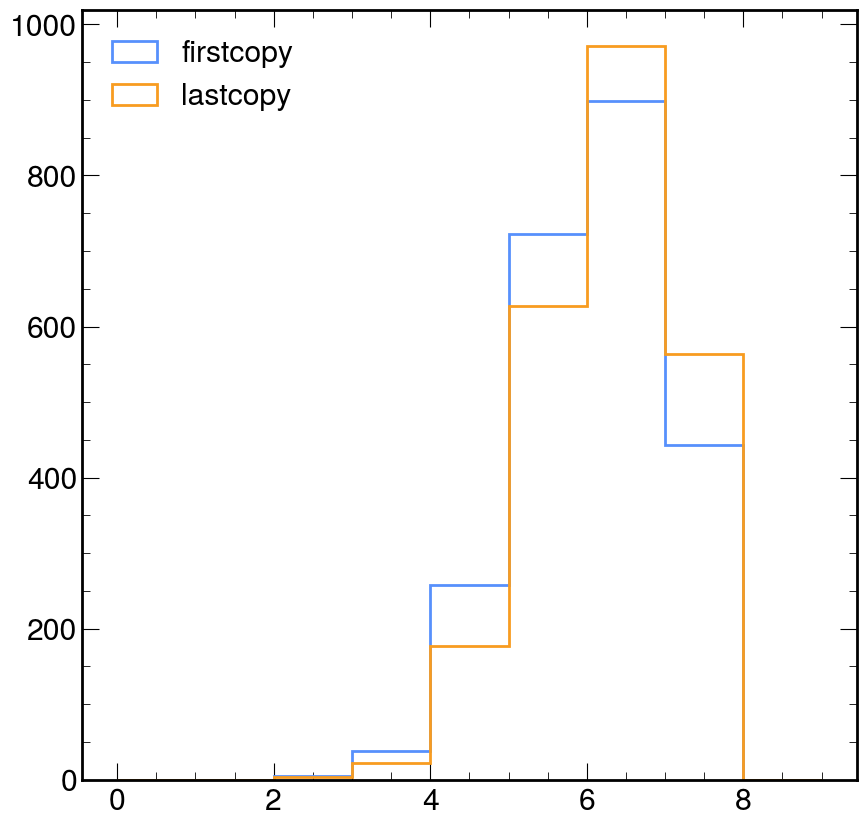

In [162]:
H1 = plt.hist(ak.sum(~ak.is_none(matched_quarks, axis=1), axis=1), range=(0,9), bins=9, label="firstcopy", histtype="step", linewidth=2)
H2 = plt.hist(ak.sum(~ak.is_none(matched_quarks_lastcopy, axis=1), axis=1), range=(0,9), bins=9, label="lastcopy",histtype="step", linewidth=2)
plt.legend()


Text(1, 0, 'N. ISR matched')

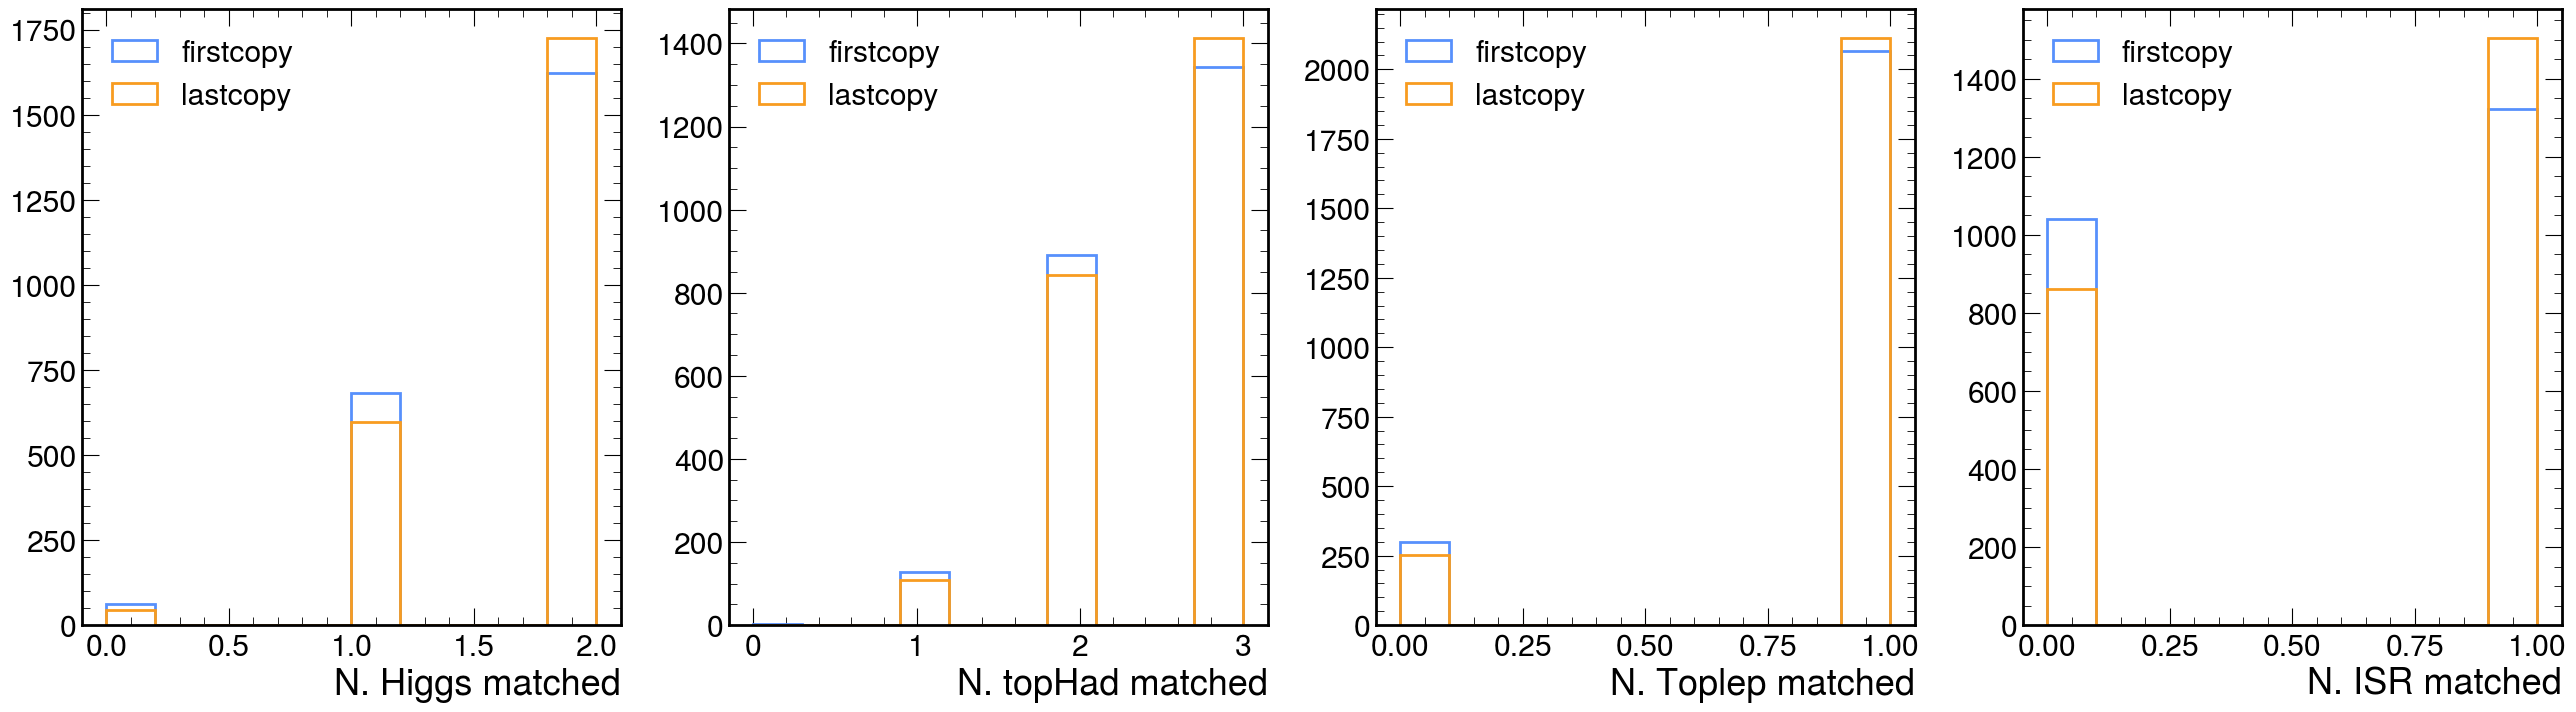

In [163]:
prov = matched_quarks.provenance
prov_lastcopy =  matched_quarks_lastcopy.provenance

fig, axs = plt.subplots(1, 4, figsize=(32,8))
axs[0].hist(ak.sum(prov ==1, axis=1),label="firstcopy", histtype="step", linewidth=2) 
axs[0].hist(ak.sum(prov_lastcopy ==1, axis=1),label="lastcopy", histtype="step", linewidth=2)
axs[0].legend()
axs[0].set_xlabel("N. Higgs matched")

axs[1].hist(ak.sum((prov == 2)|(prov==5), axis=1), label="firstcopy", histtype="step", linewidth=2) 
axs[1].hist(ak.sum((prov_lastcopy == 2)|(prov_lastcopy==5), axis=1), label="lastcopy", histtype="step", linewidth=2)
axs[1].legend()
axs[1].set_xlabel("N. topHad matched")

axs[2].hist(ak.sum(prov ==3, axis=1),label="firstcopy", histtype="step", linewidth=2) 
axs[2].hist(ak.sum(prov_lastcopy ==3, axis=1),label="lastcopy", histtype="step", linewidth=2)
axs[2].legend()
axs[2].set_xlabel("N. Toplep matched")


axs[3].hist(ak.sum(prov ==4, axis=1),label="firstcopy", histtype="step", linewidth=2) 
axs[3].hist(ak.sum(prov_lastcopy ==4, axis=1),label="lastcopy", histtype="step", linewidth=2)
axs[3].legend()
axs[3].set_xlabel("N. ISR matched")

## Looking for fully matched

In [164]:
prov = matched_quarks.provenance
matched_H = ak.sum(prov == 1, axis=1)== 2
matched_topHad = (ak.sum(prov == 2, axis=1)== 1) & (ak.sum(prov == 5, axis=1)== 2)
matched_topLep = (ak.sum(prov == 3, axis=1)== 1)
matched_isr = (ak.sum(prov == 4, axis=1)==1)
fully_matched_withISR = matched_H & matched_topHad & matched_topLep & matched_isr
fully_matched_noISR = matched_H & matched_topHad & matched_topLep

print(f"% Higgs matched, initial partons: {100*ak.sum(matched_H)/ len(matched_H):.2f}%")
print(f"% topHad matched, initial partons: {100*ak.sum(matched_topHad)/ len(matched_topHad):.2f}%")
print(f"% topLep matched, initial partons: {100*ak.sum(matched_topLep)/ len(matched_topLep):.2f}%")
print(f"% ISR gluon matched, initial partons: {100*ak.sum(matched_isr)/ len(matched_isr):.2f}%")
print(f"% fully matched (noISR), initial partons: {100*ak.sum(fully_matched_noISR)/ len(fully_matched_noISR):.2f}%")
print(f"% fully matched (withISR), initial partons: {100*ak.sum(fully_matched_withISR)/ len(fully_matched_withISR):.2f}%")


% Higgs matched, initial partons: 68.61%
% topHad matched, initial partons: 56.85%
% topLep matched, initial partons: 87.39%
% ISR gluon matched, initial partons: 55.96%
% fully matched (noISR), initial partons: 33.29%
% fully matched (withISR), initial partons: 18.74%


In [167]:
prov_lastcopy = matched_quarks_lastcopy.provenance
matched_H_lastcopy = ak.sum(prov_lastcopy == 1, axis=1)== 2
matched_topHad_lastcopy = (ak.sum(prov_lastcopy == 2, axis=1)== 1) & (ak.sum(prov_lastcopy == 5, axis=1)== 2)
matched_topLep_lastcopy = (ak.sum(prov_lastcopy == 3, axis=1)== 1)
matched_isr_lastcopy = (ak.sum(prov_lastcopy == 4, axis=1)==1)
fully_matched_withISR_lastcopy = matched_H_lastcopy & matched_topHad_lastcopy & matched_topLep_lastcopy & matched_isr_lastcopy
fully_matched_noISR_lastcopy = matched_H_lastcopy & matched_topHad_lastcopy & matched_topLep_lastcopy

print(f"% Higgs matched, lastcopy partons: {100*ak.sum(matched_H_lastcopy)/ len(matched_H_lastcopy):.2f}%")
print(f"% topHad matched, lastcopy partons: {100*ak.sum(matched_topHad_lastcopy)/ len(matched_topHad_lastcopy):.2f}%")
print(f"% topLep matched, lastcopy partons: {100*ak.sum(matched_topLep_lastcopy)/ len(matched_topLep_lastcopy):.2f}%")
print(f"% ISR gluon matched, lastcopy partons: {100*ak.sum(matched_isr_lastcopy)/ len(matched_isr_lastcopy):.2f}%")
print(f"% fully matched (noISR), lastcopy partons: {100*ak.sum(fully_matched_noISR_lastcopy)/ len(fully_matched_noISR_lastcopy):.2f}%")
print(f"% fully matched (withISR), lastcopy partons: {100*ak.sum(fully_matched_withISR_lastcopy)/ len(fully_matched_withISR_lastcopy):.2f}%")


% Higgs matched, lastcopy partons: 72.93%
% topHad matched, lastcopy partons: 59.73%
% topLep matched, lastcopy partons: 89.30%
% ISR gluon matched, lastcopy partons: 63.58%
% fully matched (noISR), lastcopy partons: 37.39%
% fully matched (withISR), lastcopy partons: 23.86%


In [168]:
print(f"Relating increase in fully matched events withISR {100*(ak.sum(fully_matched_withISR_lastcopy)-ak.sum(fully_matched_withISR))/ak.sum(fully_matched_withISR):.2f}%")
print(f"Relating increase in fully matched events noISR {100*(ak.sum(fully_matched_noISR_lastcopy)-ak.sum(fully_matched_noISR))/ak.sum(fully_matched_noISR):.2f}%")

Relating increase in fully matched events withISR 27.31%
Relating increase in fully matched events noISR 12.33%
